In [33]:
import requests
import wikipedia as wiki
import spacy
nlp = spacy.load("en_core_web_sm") 
from bs4 import BeautifulSoup as soup
import pandas as pd
from IPython.display import Image
from IPython.core.display import HTML 
from datetime import date
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
%matplotlib inline

In [34]:
def get_wikiname(name):
    wikiname = wiki.search(name)[:1]
    return wikiname

In [35]:
def get_wikiurl(wikiname):
    url = wiki.page(wikiname).url
    return url

In [36]:
def get_wikipicture(wikiname):
    image = wiki.page(wikiname).images[0]
    return image

In [37]:
def get_friends(name):
    try:
        wikiname = (wiki.search(name)[0])
        content = wiki.page(wikiname).content
    except:
        wikiname = wiki.suggest(name)
        content = wiki.page(wikiname).content
    doc = nlp(content)
    ents_list = []
    for ent in doc.ents:
        if ent.label_=="PERSON" and ent.text not in ents_list and 3 > len(ent.text.split()) > 1:
            ents_list.append(ent.text)
    return ents_list

In [38]:
def get_friendsfriends(name_list):
    friendsfriends = []
    for name in name_list:
        temp_list = []
        temp_list.append(name_list.index(name))
        temp_list.append(name)
        try: 
            temp_list.append(get_friends(name))
        except:
            pass
        friendsfriends.append(temp_list)
    return friendsfriends

In [39]:
name="obama"
wikiname = get_wikiname(name)
level_1 = get_friends(wikiname)

In [96]:
#level_2 = get_friendsfriends(level_1)

C:\Anaconda3\envs\wiki\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Anaconda3\envs\wiki\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [135]:
total_list = level_1
for i in range(len(level_2)):
    if len(level_2[i])> 2:
        for name in level_2[i][2]:
            if name not in total_list:
                total_list.append(name)

In [88]:
rows = []
for name in level_1:
    name = name.replace(" ", "_")
    link_data, data, link_person, person = "","","","" 
    try:
        link_data = f'http://dbpedia.org/data/{name}.json'
        data = requests.get(link_data).json()
        link_person = f'http://dbpedia.org/resource/{name}'
        person = data[link_person]
    except:
        pass
    try:
        birthplace = person['http://dbpedia.org/property/birthPlace'][0]['value']
    except:
        birthplace = 'NaN'
    try:
        bday = person['http://dbpedia.org/ontology/birthDate'][0]['value']
    except:
        bday = 'NaN'
    try:
        party = person['http://dbpedia.org/property/party'][0]['value']
    except:
        party = 'NaN'
    try:
        statesenate = person['http://dbpedia.org/property/stateSenate'][0]['value']
    except:
        statesenate = 'NaN'
    try:
        url = get_wikiurl(name)
    except:
        url = 'NaN'
    #picture = get_wikipicture(name)
    #Image(picture, width = 100, height = 50)             
    rows.append([name.replace("_", " "), birthplace, bday, party, statesenate, url])  
df = pd.DataFrame(rows, columns=["Name", "Birthplace", "Birthday", "Party", "Statesenate", "Url"])

C:\Anaconda3\envs\wiki\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Anaconda3\envs\wiki\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [89]:
def calculate_age(dtob):
    today = date.today()
    return today.year - dtob.year - ((today.month, today.day) < (dtob.month, dtob.day))
age_list = []
for i in range(len(df)):
    try:
        year = int(df.iloc[i]['Birthday'][0:4])
        month = int(df.iloc[i]['Birthday'][5:7])
        day = int(df.iloc[i]['Birthday'][8:10])
        age_list.append(calculate_age(date(year,month,day)))
    except:
        age_list.append("NaN")
        continue
df['Age'] = age_list
df.to_csv("wikifriends.csv")

In [258]:
df = pd.read_csv("wikifriends.csv")
df = df.drop(columns='Unnamed: 0')
df.at[df['Party']=='http://dbpedia.org/resource/Democratic_Party_(United_States)', ['Party']]="Democratic Party US"
df.at[df['Party']=='http://dbpedia.org/resource/Republican_Party_(United_States)', ['Party']]="Republican Party US"
df.at[0, 'Party'] = 'Democratic Party US'

In [259]:
df.head(5)

,Name,Birthplace,Birthday,Party,Statesenate,Url,Age
0,Hillary Clinton,"Chicago, Illinois, U.S.",1947-10-26,Democratic Party US,NaN,https://en.wikipedia.org/wiki/Hillary_Clinton,73.0
1,John McCain,"Coco Solo, Panama Canal Zone, U.S.",1936-08-29,Republican Party US,NaN,NaN,84.0
2,Joe Biden,"Scranton, Pennsylvania, U.S.",1942-11-20,Democratic Party US,NaN,NaN,78.0
3,Muammar Gaddafi,http://dbpedia.org/resource/Qasr_Abu_Hadi,NaN,http://dbpedia.org/resource/Independent_politi...,NaN,https://en.wikipedia.org/wiki/Muammar_Gaddafi,NaN
4,Mitt Romney,"Detroit, Michigan, U.S.",1947-03-12,Independent American Party,NaN,https://en.wikipedia.org/wiki/Mitt_Romney,74.0


In [260]:
df.dropna(subset = ["Party"], inplace=True)

In [261]:
from itertools import combinations
f = lambda x : pd.DataFrame(list(combinations(x.values,2)), columns=['NameA','NameB'])
df = (df.groupby('Party')['Name'].apply(f).reset_index(level=1, drop=True).reset_index())

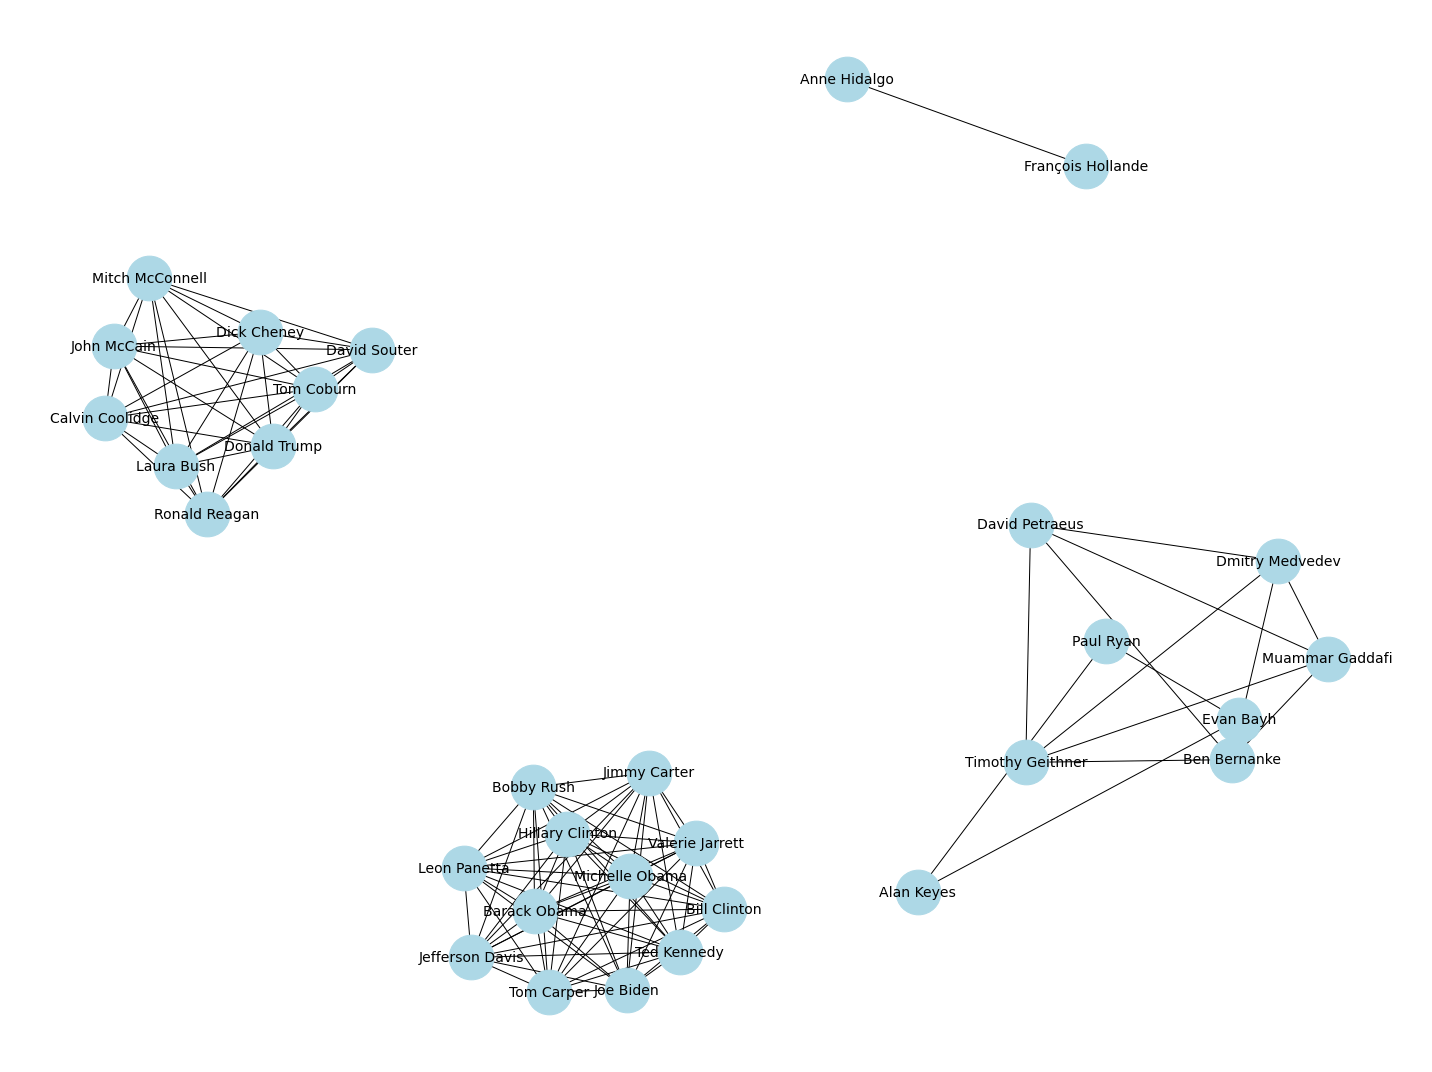

In [262]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Plotting
G = nx.Graph()
plt.figure(figsize=(20,15))

for i in range(len(df)):
    G.add_edge(df['NameA'][i], df['NameB'][i], weight=0.01)
#G.add_edge("NameA", "NameB", weight=2.6)
e = [(u, v) for (u, v, d) in G.edges(data=True)]
pos = nx.spring_layout(G, seed=16) # positions for all nodes - seed for reproducibility
#pos = nx.random_layout(G, seed=10) # positions for all nodes - seed for reproducibility
#pos = nx.shell_layout(G) # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="lightblue")
# edges
nx.draw_networkx_edges(G, pos, edgelist=e, width=1, alpha=1) # style="dashed"
# labels
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()